<a href="https://colab.research.google.com/github/KornelWitkowski/Differential-equation-solving-with-neural-network/blob/main/Differential_equations_solving_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First order ODE with the Lagaris method

At the begining, I focus on a 1st order ODE (ordinary differential equation) with use of the Lagaris method. Let us consider the following equation
\begin{equation}
\frac{d\psi(x)}{dx} + \frac{1}{5} \psi(x) = e^{-x/5} \cos(x),
\end{equation}

With the boundary condition $\psi(0) = 0$, and the domain $x \in [0,2]$. Later in the code, I will denote $f(x)=e^{-x/5} \cos(x) - \frac{1}{5} \psi(x)$.

The analytical solution of this differental equation is given by

$$\psi(x) = e^{-x/5} \sin(x)$$

In the Lagaris method, we assume the solution of the following form

$$\psi(x) = a + x \text{Net}(x)$$

Thus, as a loss function we can consider following function

\begin{equation}
\text{Loss} = \frac{1}{N}\sum_{i=1}^N \left[ \mathcal{N} (x_i) + x \frac{d \mathcal{N} (x)}{d x} - f(x_i,\Psi_t(x_i)) \right]^2.
\end{equation}

In [42]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import grad

import torch
import numpy as np

# the function in the considered ODE

f = lambda t, y:  torch.exp(-t/5)*torch.cos(t) - 1/5 * y



def nth_derivative(f, x, n):
  """
  Computes n-th derivative of the function

  Parameters:

  f: values of a function in the given points `x`
  x: points
  n: order of derivative
  """
  if n > 0:
      f = f.sum()
      for i in range(n):

          grads = grad(f, x, create_graph=True)[0]
          f = grads.sum()

      return grads
  else:
      return f


def first_order_ODE_loss_Lagaris(a, x, network, f):
    """
      Computes the loss of a neural network that solves 1st order ODE using the Lagaris method.

      Parameters:

      a: a = psi(0); boundary condition at x = 0.
      x: data points
      network: fitting model
      f: function of the ODE  
    """

    N0 = network(x)
    N1 = nth_derivative(N0, x, 1)

    loss = torch.mean(torch.square( x*N1 + N0 - f(x, a+x*network(x))  ))
    return loss


def is_model_improving(history, patience = 100):
    """
      Checks if a model improved its results (if the loss function value decreased).
      The mean value of loss function in the last 0.1*patience epochs is compared to the mean value of the prior 0.9*patience epochs.
    """
    epochs_number = len(history)
    history = np.array(history)[:,1]

    if epochs_number < patience:
      return True

    a = int(0.1*patience)
    return np.mean(history[-patience:-a]) > np.mean(history[-a:])


def fit_model_ODE_1st(input, model, batch_size, loss_function, f=f, a=0, n_epochs=1000, validation_set=None,
                      is_improving = True, n_iter=100, verbose=1, weight_decay=0):
  
  """
      The function fits model for given input and specified parameters to solve 1st order differental equation.

      Parameters:

      input: training data
      model: network to train
      f: ODE's function
      a: ODE's boundary condition at x=0
      batch_size: number of examples per update of the model weights
      n_epochs: number of full iterations througout the whole traindata set
      validation: set used to check if model is overfitting training data
      verbose: if `verbose = 1` function reports about progress
      is_improving: if `is_improving = True` traing stops if there is no improvement

      Result:
      history: values of the loss function for given epochs
  """
  
  history = []

  train_ds = TensorDataset(input)
  train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=weight_decay)

  input_size = len(train_dl)

  for epoch in range(n_epochs+1):
  

    for dane in train_dl:
      
      xb = dane[0]

      loss = loss_function(a, xb, model, f)
      loss.backward()    
      
      optimizer.step()
      optimizer.zero_grad()
 
    if validation_set is None:
      error = loss_function(a, input, model, f)
    else:
      error = loss_function(a, validation_set, model, f)

    if verbose == 1:
      if epoch%n_iter==0: print(f"Epoch: {epoch}, Loss: {round(error.item(), 5)}")    

    history.append([epoch, error.item()])

    if is_improving:
      if not is_model_improving(history, n_iter):
        print("Model is not improving")
        print(f"Epoch: {epoch}, Loss: {round(loss.item(), 5)}")
        return np.array(history)

    
  return np.array(history)

 I use a bit broaded domain for the test data set to check wheter neural network are able to extrapolate their results properly. 

In [3]:
# Train and test data.

x_train = torch.arange(start=0.00, end=2.00, step=0.01, requires_grad=True).reshape(-1,1)
x_test = torch.arange(start=-0.125, end=2.225, step=0.10, requires_grad=True).reshape(-1,1)

In [27]:
from torch import nn
network_1 = nn.Sequential(nn.Linear(1, 32),
              nn.ReLU(),
              nn.Linear(32, 16),
              nn.ReLU(),
              nn.Linear(16, 1))

history_1 = fit_model_ODE_1st(input=x_train,
                            model=network_1,
                            batch_size=20,
                            loss_function=first_order_ODE_loss_Lagaris,
                            validation_set=x_test,
                            n_epochs=2000,
                            n_iter=200
                            )

Epoch: 0, Loss: 0.50126
Epoch: 200, Loss: 0.3067
Epoch: 400, Loss: 0.22137
Epoch: 600, Loss: 0.14616
Epoch: 800, Loss: 0.08958
Epoch: 1000, Loss: 0.05329
Epoch: 1200, Loss: 0.03119
Epoch: 1400, Loss: 0.01917
Epoch: 1600, Loss: 0.0131
Epoch: 1800, Loss: 0.00969
Epoch: 2000, Loss: 0.0079


Let us visualize how good is the network

In [36]:
def calculate_solution_Lagaris(a, network, x):
  """
    Calculates the value of psi(x) from a neural network in the Lagaris method
  """
  return (a + x*network(x)).detach().numpy()


def Y(t):
  """
    The exact solution of the considered ODE
  """
  return np.exp(-t/5)*np.sin(t)  

In [34]:
import matplotlib.pyplot as plt

def plot_results(model, formula, x_train, Y, history, a=0, x_test=None, title=None):
  """
    formula:  function that calculates the solution with 
              arguments (boundary_condition, model, data_points)
              in the considered method
  """

  y_train_pred = formula(a, model, x_train)
  y_train_true = Y(x_train.detach().numpy())
  x_train = x_train.detach().numpy()

  fig, ax = plt.subplots(1,3, figsize=(24,8))

  fig.suptitle(title, fontsize=20)

  ax[0].scatter(x_train, y_train_pred, label="Trainset: Prediction", s=11, color="r")
  ax[0].plot(x_train, y_train_true, label="Trainset: True") 

  if x_test is not None:
      y_test_pred = formula(a, model, x_test)
      y_test_true = Y(x_test.detach().numpy())
      x_test = x_test.detach().numpy()
      ax[0].scatter(x_test, y_test_pred, label="Testset: Prediction", s=25, color="b")
      ax[0].plot(x_test, y_test_true, label="Testset: True") 


  ax[0].legend(fontsize=14)   
  ax[0].set_xlabel("x", fontsize=18)
  ax[0].set_ylabel(r"$\psi$(x)", fontsize=18)
  ax[0].grid(True) 

  ax[1].scatter(y_train_true, y_train_pred, s=11, color="r", label="Trainset")
  ax[1].plot([-5,5], [-5, 5], color="black", label="Expected")

  y_max = y_train_true.max()
  y_min = y_train_true.min()
  x_max = y_train_pred.max()
  x_min = y_train_pred.min()

  ax[1].set_ylim([y_min - 0.1*(y_max - y_min), y_max + 0.1*(y_max - y_min)])
  ax[1].set_xlim([x_min - 0.1*(x_max - x_min), x_max + 0.1*(x_max - x_min)])

  if x_test is not None:
      ax[1].scatter(y_test_true, y_test_pred, s=25, color="b", label="Testset")

  ax[1].set_xlabel("Y predicted", fontsize=18)
  ax[1].set_ylabel(r"Y true", fontsize=18)
  ax[1].legend(fontsize=14) 
  ax[1].grid(True) 



  ax[2].plot(history[:,0], history[:,1]) 
  ax[2].set_xlabel("Epoch", fontsize=18)
  ax[2].set_ylabel("Loss", fontsize=18)
  ax[2].grid(True) 

  return

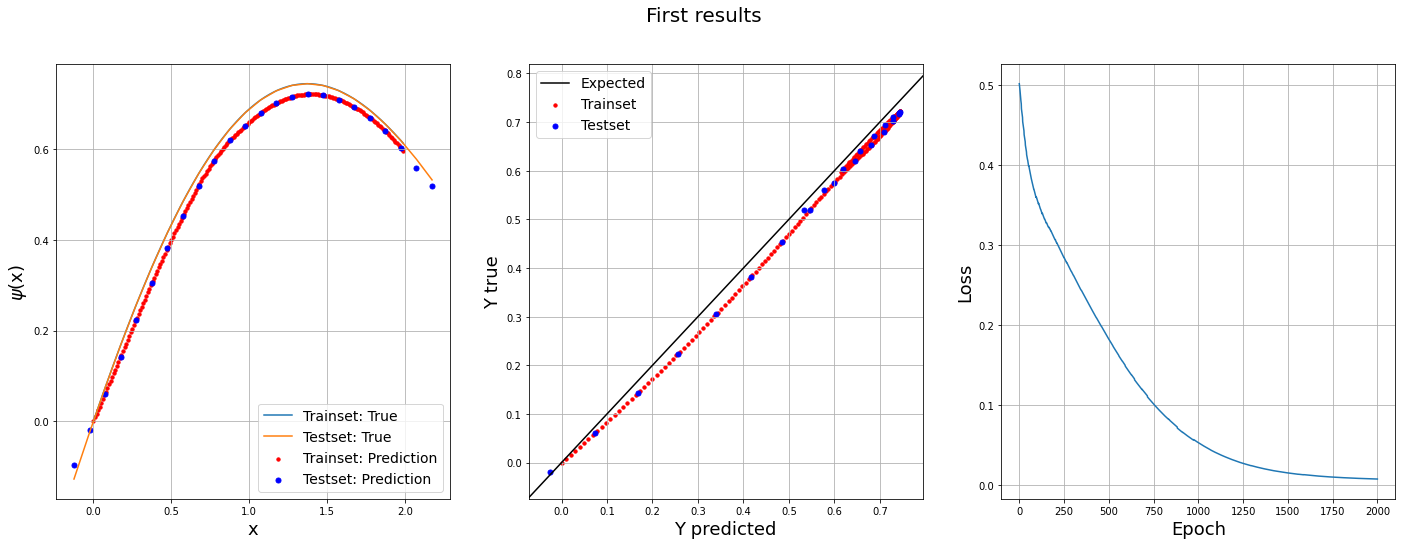

In [37]:
plot_results(network_1, calculate_solution_Lagaris, x_train, Y, history_1, 0, x_test, title="First results")

The fit is pretty good, and it seems that longer traning could improve the results.

## Experiments with the model sizes

Now, let us check the influence of the neural network size. We consider different numbers in the hidden layers. The rest remains the same.

Model with the network size: 2

Epoch: 0, Loss: 0.22425
Epoch: 500, Loss: 0.13971
Epoch: 1000, Loss: 0.08762
Epoch: 1500, Loss: 0.03763
Epoch: 2000, Loss: 0.01075


Model with the network size: 4

Epoch: 0, Loss: 0.19436
Epoch: 500, Loss: 0.07442
Epoch: 1000, Loss: 0.03222
Epoch: 1500, Loss: 0.01787
Epoch: 2000, Loss: 0.01433


Model with the network size: 8

Epoch: 0, Loss: 0.20396
Epoch: 500, Loss: 0.09577
Epoch: 1000, Loss: 0.02083
Epoch: 1500, Loss: 0.00397
Epoch: 2000, Loss: 0.00218


Model with the network size: 16

Epoch: 0, Loss: 0.2699
Epoch: 500, Loss: 0.0475
Epoch: 1000, Loss: 0.01233
Epoch: 1500, Loss: 0.00857
Epoch: 2000, Loss: 0.00765


Model with the network size: 32

Epoch: 0, Loss: 0.42651
Epoch: 500, Loss: 0.0447
Epoch: 1000, Loss: 0.00657
Epoch: 1500, Loss: 0.00401
Epoch: 2000, Loss: 0.00342


Model with the network size: 64

Epoch: 0, Loss: 0.45178
Epoch: 500, Loss: 0.00349
Epoch: 1000, Loss: 0.00138
Epoch: 1500, Loss: 0.00102
Epoch: 2000, Loss: 0.0008




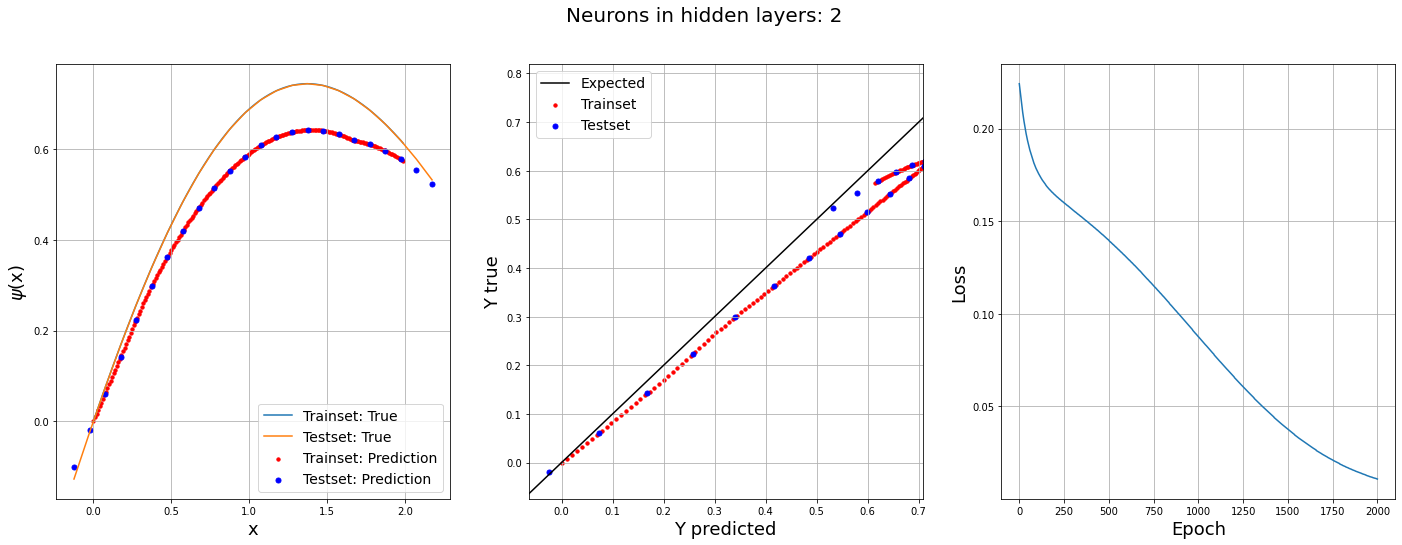

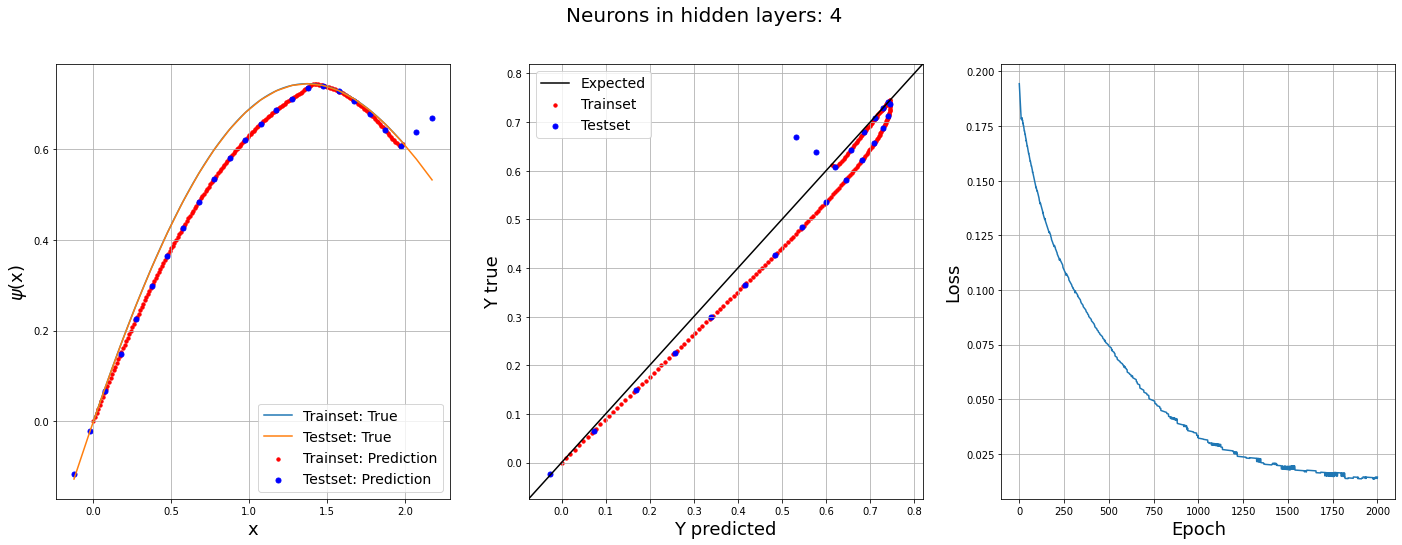

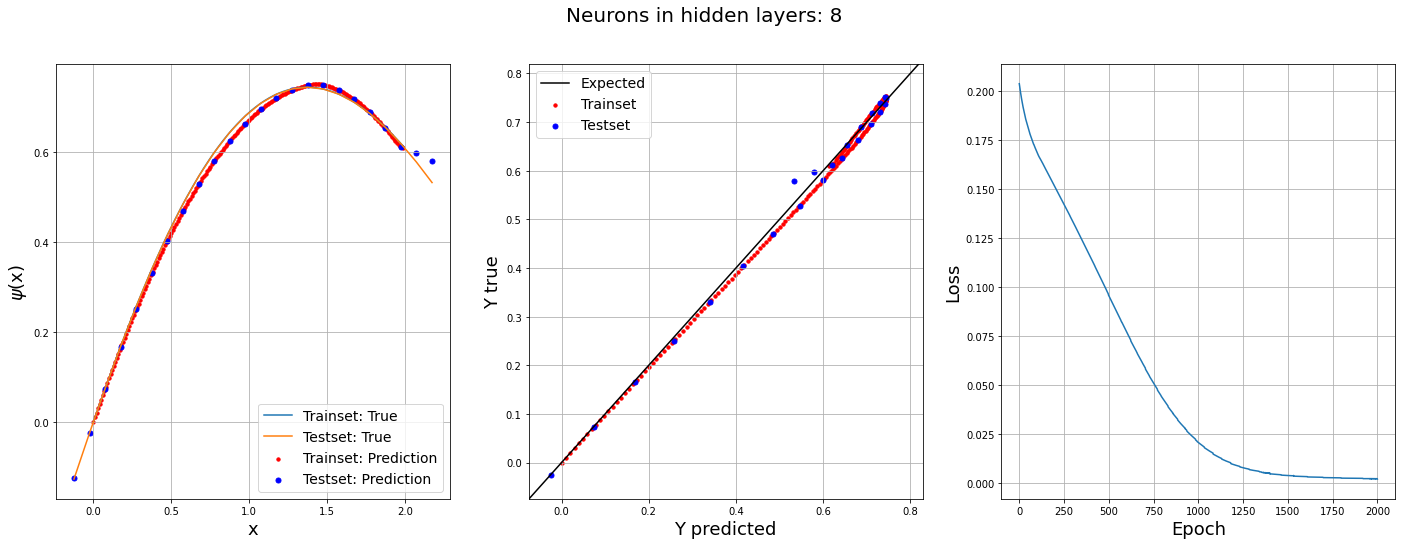

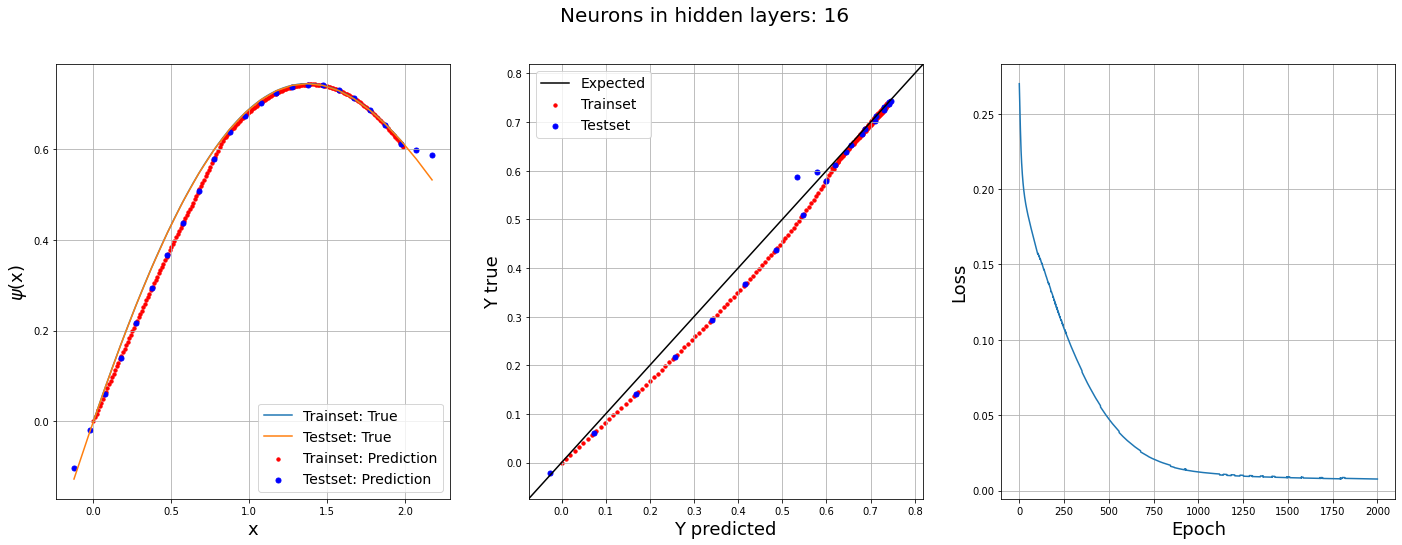

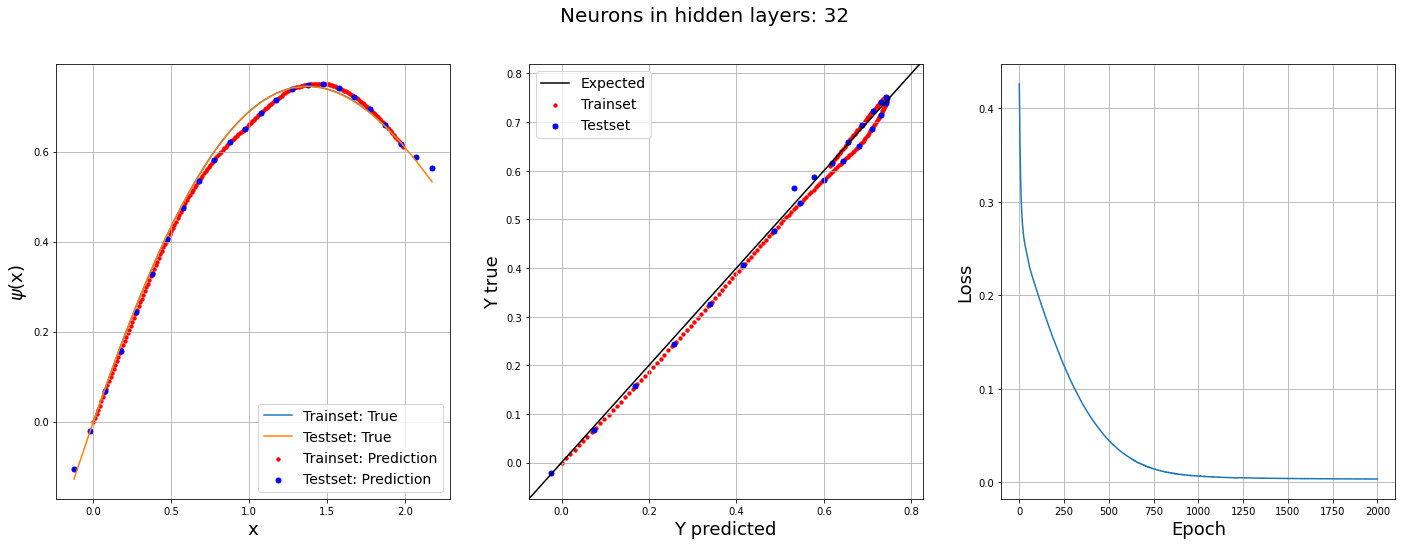

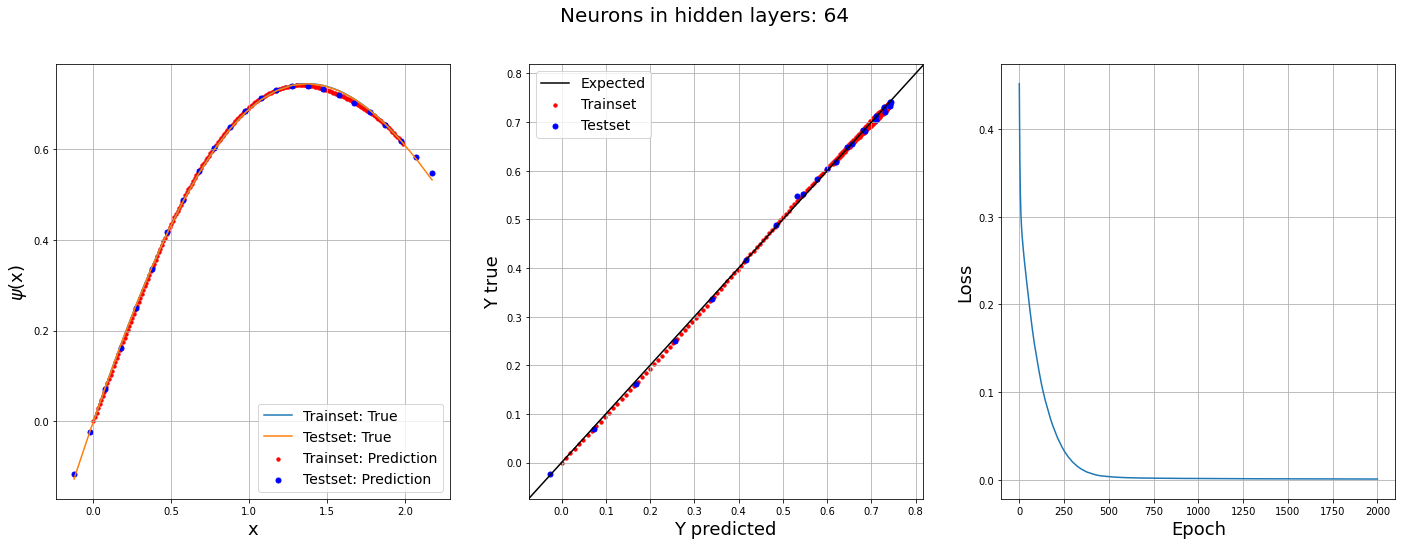

In [38]:
network_sizes = [2, 4, 8, 16, 32, 64]

histories_network_sizes = []
models_network_sizes = []

for size in network_sizes:

  print(f"Model with the network size: {size}\n")

  model =  nn.Sequential(nn.Linear(1, size),
              nn.ReLU(),
              nn.Linear(size, size),
              nn.ReLU(),
              nn.Linear(size, 1))

  history = fit_model_ODE_1st(input=x_train,
                              model=model,
                              batch_size=10,
                              loss_function=first_order_ODE_loss_Lagaris,
                              validation_set=x_train,
                              n_epochs=2000,
                              n_iter=500,
                              verbose=1
                              )
  
  print(f"\n==============================\n")
  
  plot_results(model, calculate_solution_Lagaris, x_train, Y, history, 0, x_test, title=f"Neurons in hidden layers: {size}")

  histories_network_sizes.append(history)
  models_network_sizes.append(model);

One can notice that the neural network extrapolates pretty well the real solution. The predicted values are close to the exact values outside the train data range. Let us check how it works for much broader domain using the largest network

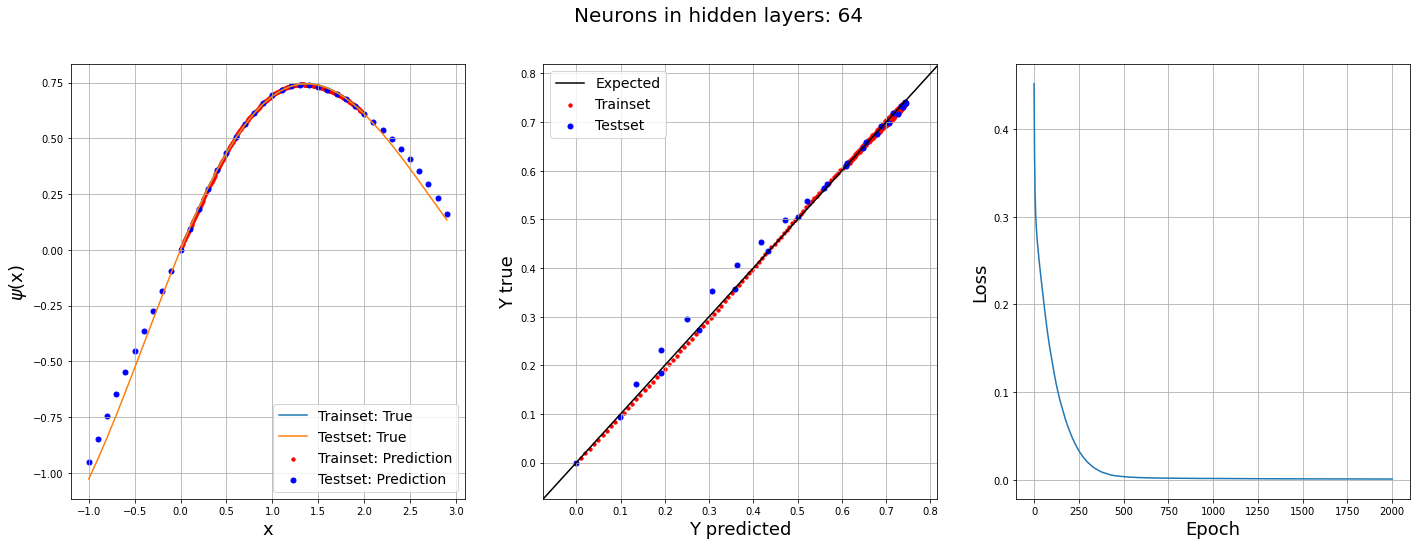

In [39]:
x_test_extended = torch.arange(start=-1.0, end=3.0, step=0.10, requires_grad=True).reshape(-1,1)
model = models_network_sizes[-1]

plot_results(model, calculate_solution_Lagaris, x_train, Y, history, 0, x_test_extended , title=f"Neurons in hidden layers: {size}")

It is not ideal, but also not that bad.

# First order ODE with the PINN method

Now, the PINN method will be use for the same ODE

\begin{equation}
\frac{d\psi(x)}{dx} + \frac{1}{5} \psi(x) = e^{-x/5} \cos(x),
\end{equation}

With the boundary condition $\psi(0) = 0$, and the domain $x \in [0,2]$.

The analytical solution of this differental equation is given by

$$\psi(x) = e^{-x/5} \sin(x)$$

In the PINN method we assume the solution of the following form

$$\psi(x) =  \text{Net}(x)$$

In this method, a neural network doesn't satisfy the boundary condition by default from the definition, and it must be included in the loss function.
Thus, as a loss function we can consider following function

\begin{equation}
MSE =   \gamma \, (N(0) - a)^2 + \frac{1}{N}\sum_{i=1}^N \left( \frac{d}{dx}  \mathcal{N} (x_i)  + \frac{1}{5}  \mathcal{N}(x_i) -  e^{-x_i/5} \cos(x_i) \right)^2 .
\end{equation}

The coefficient $\gamma$ informs how strongly the boundary condition is imposed.

In [43]:
# The method requires a different defintion of loss function

def first_order_ODE_loss_PINN(a, x, network, f):

    N0 = network(x)
    N1 = nth_derivative(N0, x, 1)

    f0 = f(x, N0)

    tensor_zero = torch.zeros(1)

    loss = torch.mean(torch.square( N1 - f0 )) + torch.mean(torch.square(  network(tensor_zero) - a))
    return loss

We use a model that has the idential architecture as the first model in the Lagaris method.

In [49]:
from torch import nn
network = nn.Sequential(nn.Linear(1, 32),
              nn.ReLU(),
              nn.Linear(32, 16),
              nn.ReLU(),
              nn.Linear(16, 1))

history = fit_model_ODE_1st(input=x_train,
                            model=network,
                            batch_size=20,
                            loss_function=first_order_ODE_loss_PINN,
                            validation_set=x_test,
                            n_epochs=2000,
                            n_iter=200)

Epoch: 0, Loss: 0.39288
Epoch: 200, Loss: 0.31882
Epoch: 400, Loss: 0.26525
Epoch: 600, Loss: 0.225
Epoch: 800, Loss: 0.18505
Epoch: 1000, Loss: 0.15207
Epoch: 1200, Loss: 0.12793
Epoch: 1400, Loss: 0.10971
Epoch: 1600, Loss: 0.09729
Epoch: 1800, Loss: 0.08746
Epoch: 2000, Loss: 0.08215


In [50]:
def calculate_solution_PINN(a, network, x):
  """
    Calculates the value of psi(x) from a neural network in the Lagaris method
  """
  return network(x).detach().numpy()

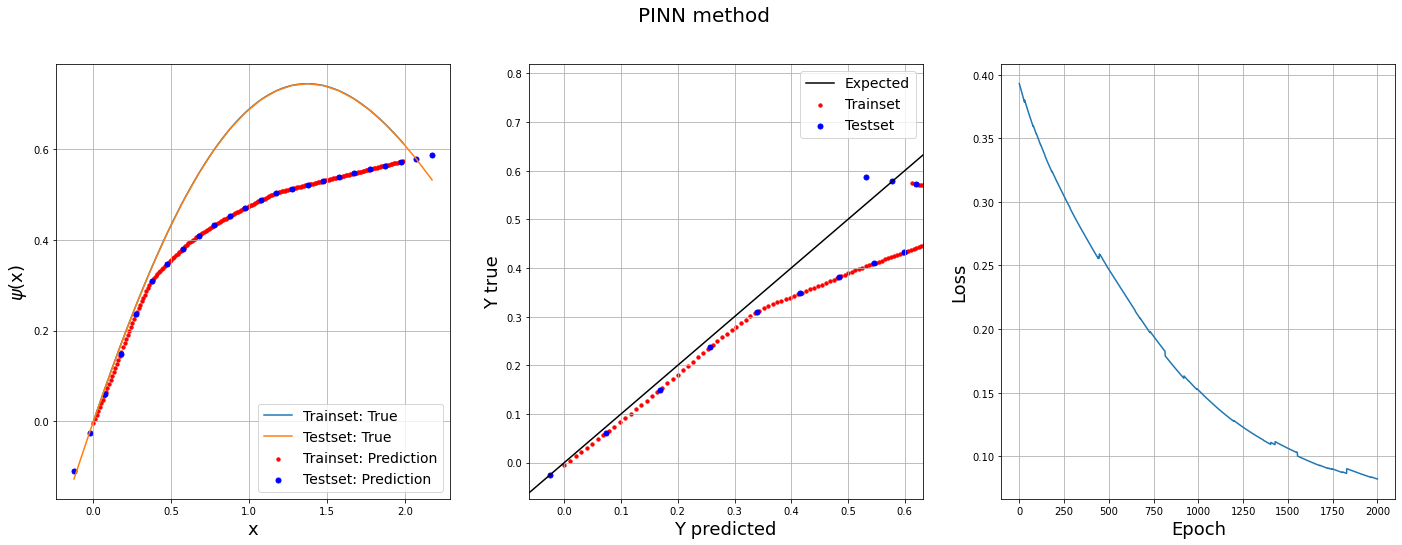

In [51]:
plot_results(network, calculate_solution_PINN, x_train, Y, history, 0, x_test, title="PINN method")

The method produced worse results for the same parameters. However, it learns much slower, and it is undertrained, so we can check how the result will look after more epochs


 

In [52]:
# continuation of the previous training
history_2 = fit_model_ODE_1st(input=x_train,
                              model=network,
                              batch_size=20,
                              loss_function=first_order_ODE_loss_PINN,
                              validation_set=x_test,
                              n_epochs=10000,
                              n_iter=1000)

Epoch: 0, Loss: 0.08213
Epoch: 1000, Loss: 0.05178
Epoch: 2000, Loss: 0.03734
Epoch: 3000, Loss: 0.03213
Epoch: 4000, Loss: 0.02823
Epoch: 5000, Loss: 0.02679
Epoch: 6000, Loss: 0.02521
Epoch: 7000, Loss: 0.02413
Model is not improving
Epoch: 7178, Loss: 0.02319


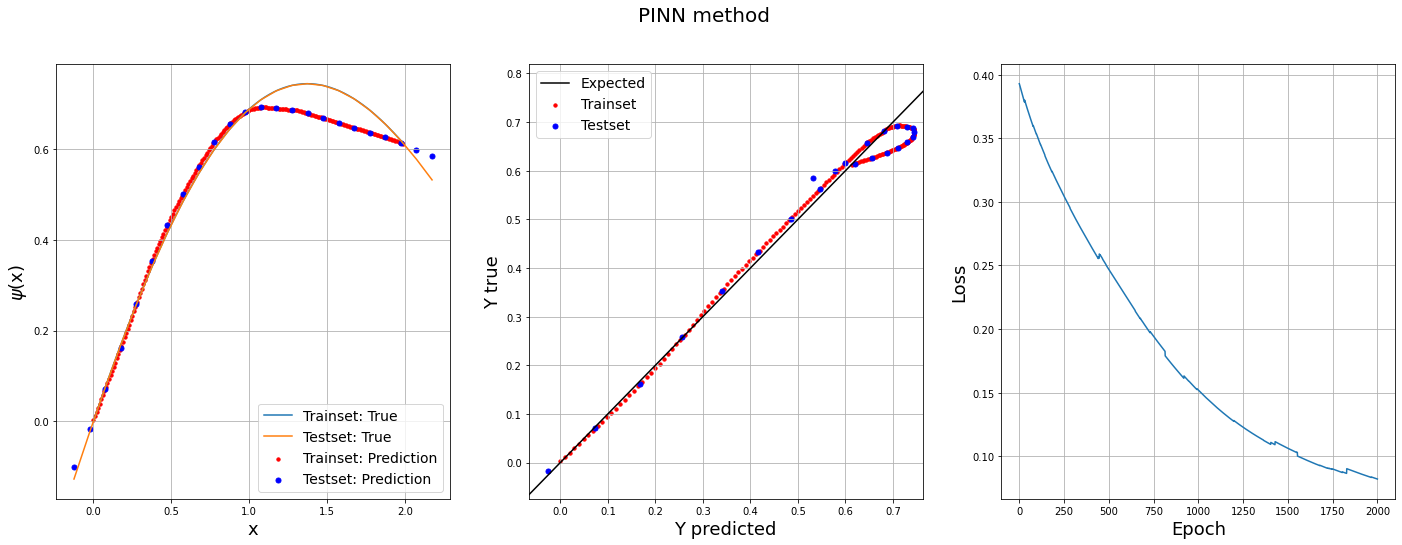

In [53]:
plot_results(network, calculate_solution_PINN, x_train, Y, history, 0, x_test, title="PINN method")

Let us try out another architecture with the bigger number of hidden units and more smooth activation functions

In [58]:
network_3 = nn.Sequential(nn.Linear(1, 64),
                          nn.Tanh(),
                          nn.Linear(64, 64),
                          nn.Tanh(),
                          nn.Linear(64, 1))

history_3 = fit_model_ODE_1st(input=x_train,
                              model=network_3,
                              batch_size=20,
                              loss_function=first_order_ODE_loss_PINN,
                              validation_set=x_test,
                              n_epochs=5000,
                              n_iter=1000)

Epoch: 0, Loss: 0.39514
Epoch: 1000, Loss: 0.05857
Epoch: 2000, Loss: 0.02086
Epoch: 3000, Loss: 0.01149
Epoch: 4000, Loss: 0.00873
Epoch: 5000, Loss: 0.00744


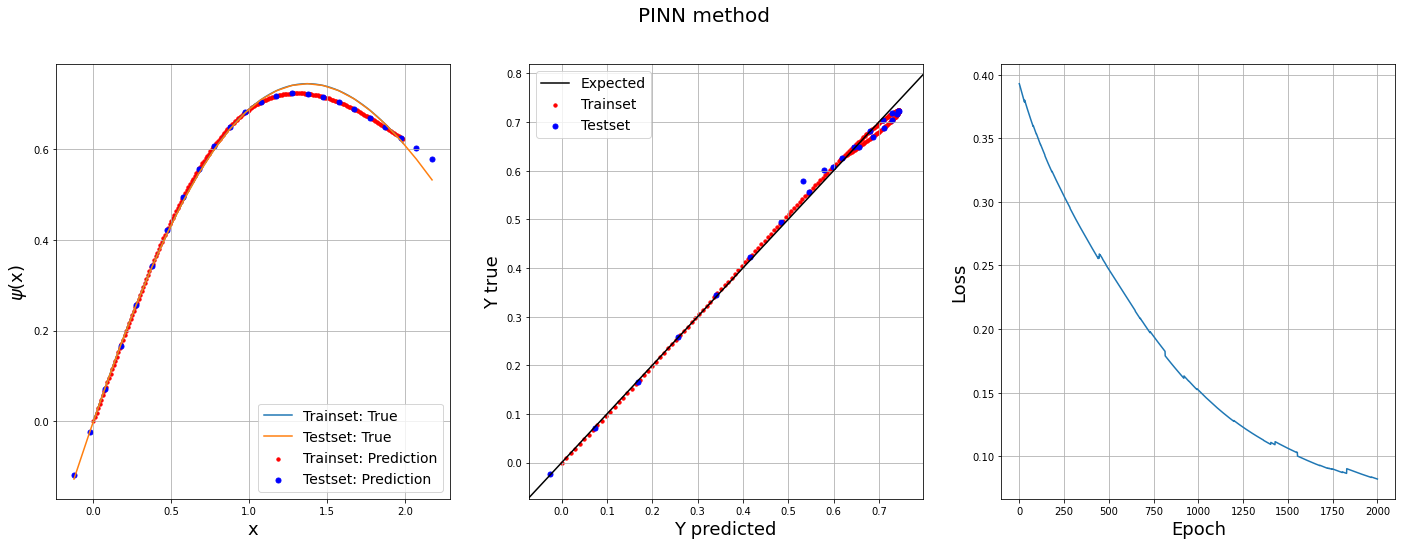

In [59]:
plot_results(network_3, calculate_solution_PINN, x_train, Y, history, 0, x_test, title="PINN method")

# Second order ODE with the Lagaris method

Now, I consider the second order ODE

$$\frac{d^2 \psi(x)}{dx^2} + \frac{1}{5} \frac{d\psi(x)}{dx}+\psi(x) = - \frac{1}{5} e^{-x/5} \cos(x),$$

with the boundary conditions 

$$\psi(0)=0, \quad \frac{d\psi(0)}{dx}=1 $$

The exact solution reads

$$\psi(x) = e^{-x/5}\sin(x)$$

We assume the domain $x \in [0, 3]$.

Using Lagaris method we must assume solution in the form 
$$ \psi(x) = a + b x + x^2 \text{Net}(x)$$

Putting it in the ODE one gets loss function

In [117]:
import numpy as np

def ODE_second_order_loss(a, b, x, network):
    N0 = network(x)
    N1 = nth_derivative(N0, x, 1) # first derivative
    N2 = nth_derivative(N0, x, 2) # second derivative

    loss = torch.mean(torch.square( 2*N0 + 4 * x * N1 + x**2 * N2
                                   + 1/5 * (b + 2*x* N0 + x**2 * N1)
                                   + a + b*x + x**2 * N0
                                   + 1/5 * torch.exp(-x/5) * torch.cos(x)))
    return loss

In [119]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


def fit_model_ODE_2nd(input, model, batch_size, a=0, b=1, n_epochs=100, n_iter=10, verbose=1, weight_decay=0):
  
  history = []

  train_ds = TensorDataset(input)
  train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=weight_decay)

  input_size = len(train_dl)

  for epoch in range(n_epochs+1):
  
    error = 0

    for dane in train_dl:
      
      xb = dane[0]

      loss = ODE_second_order_loss(a , b, xb, model)
      error+= loss/(input_size/batch_size)
        
      loss.backward()    
      
      optimizer.step()
      optimizer.zero_grad()
 
    if verbose == 1:
      if epoch%n_iter==0: print(f"Epoch: {epoch}, Loss: {round(loss.item(), 4)}")

    history.append([epoch, error.item()])
    
  return np.array(history)

In [120]:
network = nn.Sequential(nn.Linear(1, 16),
              nn.Tanh(),
              nn.Linear(16, 8),
              nn.Tanh(),
              nn.Linear(8, 1))

x = torch.arange(start=0.00, end=3.00, step=0.01, requires_grad=True).reshape(-1,1)

In [121]:
history = fit_model_ODE_2nd(input=x,
                            model=network,
                            batch_size=20,
                            n_epochs=1000,
                            n_iter=100
                            )

Epoch: 0, Loss: 0.9051
Epoch: 100, Loss: 0.0424
Epoch: 200, Loss: 0.0349
Epoch: 300, Loss: 0.027
Epoch: 400, Loss: 0.0157
Epoch: 500, Loss: 0.0098
Epoch: 600, Loss: 0.0135
Epoch: 700, Loss: 0.0033
Epoch: 800, Loss: 0.0058
Epoch: 900, Loss: 0.0052
Epoch: 1000, Loss: 0.0033


In [127]:
def calculate_solution_Lagaris_ODE_2nd(a, b, network, x):
  return a + b*x + x**2 * network(x)

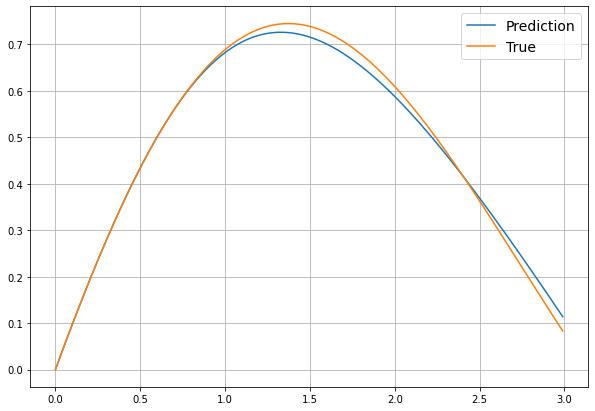

In [128]:
import matplotlib.pyplot as plt

Y_pred = calculate_solution_Lagaris_ODE_2nd(0, 1, network,x).detach().numpy()
Y_true = Y(x.detach().numpy())
X_np = x.detach().numpy()

plt.figure(figsize=(10, 7))
plt.plot(X_np, Y_pred, label='Prediction')
plt.plot(X_np, Y_true, label="True")
plt.legend(fontsize=14)
plt.grid(True)

One can see that the method effectively solve 2nd order ODE. 

Let us try with much smaller number of points 

In [135]:
from torch import nn

network = nn.Sequential(nn.Linear(1, 64),
              nn.Tanh(),
              nn.Linear(64, 64),
              nn.Tanh(),
              nn.Linear(64, 1))

x_train = torch.arange(start=0.00, end=3.00, step=0.3, requires_grad=True).reshape(-1,1)

history = fit_model_ODE_2nd(input=x,
                            model=network,
                            batch_size=20,
                            n_epochs=10000,
                            n_iter=1000
                            )

Epoch: 0, Loss: 4.854
Epoch: 1000, Loss: 0.0044
Epoch: 2000, Loss: 0.0023
Epoch: 3000, Loss: 0.0015
Epoch: 4000, Loss: 0.0012
Epoch: 5000, Loss: 0.0011
Epoch: 6000, Loss: 0.001
Epoch: 7000, Loss: 0.0009
Epoch: 8000, Loss: 0.0009
Epoch: 9000, Loss: 0.0008
Epoch: 10000, Loss: 0.0008


For traning I only used 10 points. Let check if it interpolates properly

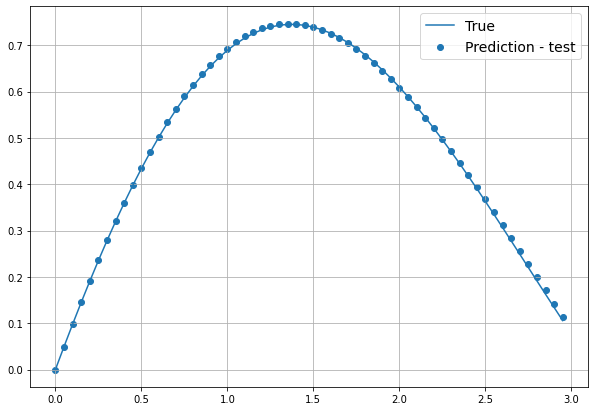

In [142]:
x_test = torch.arange(start=0.00, end=3.00, step=0.05, requires_grad=True).reshape(-1,1)

Y_pred_test = calculate_solution_Lagaris_ODE_2nd(0, 1, network, x_test).detach().numpy()
Y_true_test = Y(x_test.detach().numpy())
X_test = x_test.detach().numpy()


plt.figure(figsize=(10, 7))
plt.scatter(X_test, Y_pred_test, label='Prediction - test')
plt.plot(X_test, Y_true_test, label="True")
plt.legend(fontsize=14)
plt.grid(True)

Looks great

# Second order PDE with the Lagaris method $-$ The wave equation

Now, we will consider a partial differental equation, so the loss function will require partial derivatives. As an example, I take the wave equation

$$\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2}=0$$

With initial conditions

$$u(x,0) = f(x)$$

$$\frac{\partial}{\partial t}u(x,0) = g(x)$$

and boundary constraints $u(0,t) = u(L,0) = 0$

The PINN method will be used

$$\text{Loss} = MSE \left( \frac{\partial^2 }{\partial t^2} \cal{N}(x,t) -  c^2 \frac{\partial^2 }{\partial x^2} \cal{N}(x,t)\right)+ MSE \left(u(x,0) - f(x) \right) + MSE \left(\frac{\partial}{\partial t} u(x,0) -g(x) \right) + MSE \left( u(0,t)  \right)  + MSE \left( u(L,t)  \right) $$

For simplicity I assume $g \equiv 0$

As a domain I choose $(x, t)\in[0,10] \times [0,10]$. Let us construct a function to generate grids

In [60]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def grid_gen(size, xmin=0, xmax=10, tmin=0, tmax=10):
    x_d = ((np.linspace(xmin, xmax, size)[:, None]).T)[0]
    t_d = ((np.linspace(tmin, tmax, size)[:, None]).T)[0]
    x_temp, t_temp = [], []

    for i in range(size):
        for x_i in x_d: x_temp.append(x_i)
        for t_i in range(size): t_temp.append(t_d[i])

    x, t = torch.FloatTensor(x_temp).to(device), torch.FloatTensor(t_temp).to(device)
    xt = torch.stack([x, t], 1)

    xt.requires_grad = True
    return xt

I consider the simplest single-mode initial condition:

$$ f(x) = \sin\left(\frac{2\pi}{L} x\right) $$

The exact solution of the ODE, in such the case, reads

$$u(x,t) = \sin\left(\frac{2\pi}{L} x\right) \cos\left(\frac{2\pi}{L/c} t\right)$$

In [62]:
# initial condition
f = lambda xy: torch.sin(2*0.314*xy[:,0])

# exact solution
u_true = lambda xy: torch.sin(2*0.314*xy[:,0]) * torch.cos(2*0.314*xy[:,1])

In [63]:
# the loss function of the wave equation in the Lagaris method

def loss_PDE(xt, network, f=f, c=1, gamma=3):


    size = int(np.sqrt(xt.size()[0]))
    xt0 = xt[:size]

    a = xt[:size, 0].reshape(size,1)
    b = torch.zeros(size).reshape(size,1)
    d = 10* torch.ones(size).reshape(size,1)

    x0t = torch.cat((b,a), 1)
    x10t = torch.cat((d,a), 1)

    N00 = network(xt)

    grads, = torch.autograd.grad(N00, xt, grad_outputs=N00.data.new(N00.shape).fill_(1), create_graph=True, only_inputs=True)
    N10, N01 = grads[:, 0], grads[:, 1]
    
    grads_x, = torch.autograd.grad(N10, xt, grad_outputs=N10.data.new(N10.shape).fill_(1), create_graph=True, only_inputs=True)
    N20, N11 = grads_x[:, 0], grads_x[:, 1]

    grads_t, = torch.autograd.grad(N01, xt, grad_outputs=N01.data.new(N01.shape).fill_(1), create_graph=True, only_inputs=True)
    N11t, N02 = grads_t[:, 0], grads_t[:, 1]

    f00 = f(xt0).reshape(size, 1)


    nxt0 = network(xt0)
    fxt0 = f(xt0).reshape(size, 1).reshape(nxt0.shape)


    loss = torch.mean(torch.square(N20 - c**2 * N02)) + torch.mean(torch.square(nxt0 - fxt0)) + torch.mean(torch.square(N01[:size])) \
             + torch.mean(torch.square(network(x0t)  )) + torch.mean(torch.square(network(x10t)  ))


    return loss

The form of loss function is complicated, so it is good to ensure if it is properly defined. The result should be close to zero for the exact solution

In [65]:
xt_train = grid_gen(200)

loss_PDE(xt_train, u_true, f=f, c=1, gamma=3)

tensor(5.0952e-06, grad_fn=<AddBackward0>)

Hence, it seems to be well defined. 

Let us fit the first model

In [102]:
def is_model_improving(history, patience = 100):
    """
      Checks if a model improved its results (if the loss function value decreased).
      The mean value of loss function in the last 0.1*patience epochs is compared to the mean value of the prior 0.9*patience epochs.
    """
    epochs_number = len(history)
    history = np.array(history)[:,1]

    if epochs_number < patience:
      return True

    a = int(0.1*patience)
    return np.mean(history[-patience:-a]) > np.mean(history[-a:])


def fit_model_PDE(input, model, optimizer, batch_size=32,
                  f=f, n_epochs=100, n_iter=10,
                  verbose=1, gamma=3, c=1, is_improving=False):
  
  history = []

  for epoch in range(n_epochs+1):
  
      loss = loss_PDE(input, model, f, c=c, gamma=gamma)
      error= loss
        
      loss.backward()       
      optimizer.step()
      optimizer.zero_grad()

      if verbose == 1:
        if epoch%n_iter==0: print(f"Epoch: {epoch}, Loss: {round(error.item(), 5)}") 

      if is_improving:
        if not is_model_improving(history, n_iter):
          print("Model is not improving")
          print(f"Epoch: {epoch}, Loss: {round(loss.item(), 5)}")
          return np.array(history)   

      history.append([epoch, error.item()])


  return np.array(history)

In [104]:
xt_train = grid_gen(100)

network = nn.Sequential(nn.Linear(2, 128),
                            nn.Tanh(),
                            nn.Linear(128, 128),
                            nn.Tanh(),
                            nn.Linear(128, 1))


optimizer = torch.optim.SGD(network.parameters(), lr=1e-4, momentum=0.9)

history = fit_model_PDE(xt_train,
                        network,
                        optimizer,
                        n_epochs=2000,
                        n_iter=100,
                        f=f)

Epoch: 0, Loss: 0.78632
Epoch: 100, Loss: 0.39749
Epoch: 200, Loss: 0.32801
Epoch: 300, Loss: 0.2943
Epoch: 400, Loss: 0.27224
Epoch: 500, Loss: 0.25527
Epoch: 600, Loss: 0.2414
Epoch: 700, Loss: 0.22989
Epoch: 800, Loss: 0.22028
Epoch: 900, Loss: 0.21221
Epoch: 1000, Loss: 0.20537
Epoch: 1100, Loss: 0.19954
Epoch: 1200, Loss: 0.1945
Epoch: 1300, Loss: 0.19009
Epoch: 1400, Loss: 0.18621
Epoch: 1500, Loss: 0.18274
Epoch: 1600, Loss: 0.17961
Epoch: 1700, Loss: 0.17677
Epoch: 1800, Loss: 0.17418
Epoch: 1900, Loss: 0.17179
Epoch: 2000, Loss: 0.16959


In [105]:
def plot_history(history):
    fig = plt.figure(figsize=(10, 7))
    plt.plot(history[:,0], history[:,1]) 
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.grid(True) 


def plot_evolution(xt, model, title=None, ylim=None):
    """
        function plots several moments in time of the model prediction and
        the exact solution.
    """

    size = int(np.sqrt(xt.size()[0]))
    fig, ax = plt.subplots(1, 5, figsize=(24,8))
    fig.suptitle(title, fontsize=20)

    for j, i in enumerate([0, int(0.1*size), int(0.2*size), int(0.3*size), int(0.8*size)]):
      

      xt0 = xt[i*size:(i+1)*size]
      u0 = u_true(xt0).detach().numpy()
      n0 = model(xt0).reshape(size).detach().numpy()
      xt0 = xt0[:,0].detach().numpy()
      ax[j].plot(xt0, n0, label=f"Pred t={10*i/size}") 
      ax[j].plot(xt0, u0, label=f"True t={10*i/size}") 
      ax[j].grid(True)
      ax[j].legend(fontsize=14)
      if not (ylim is  None):
        ax[j].set_ylim(ylim)

    return

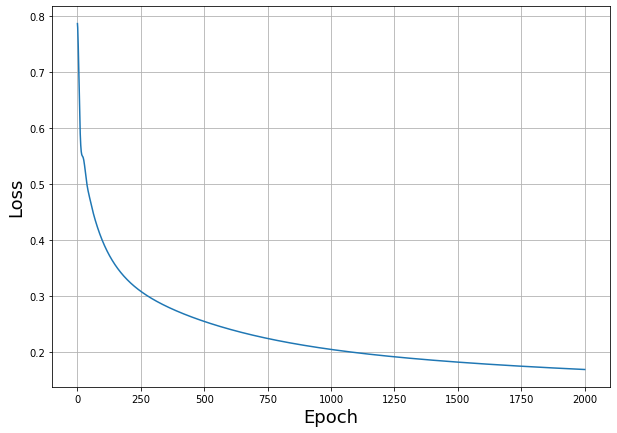

In [106]:
plot_history(history)

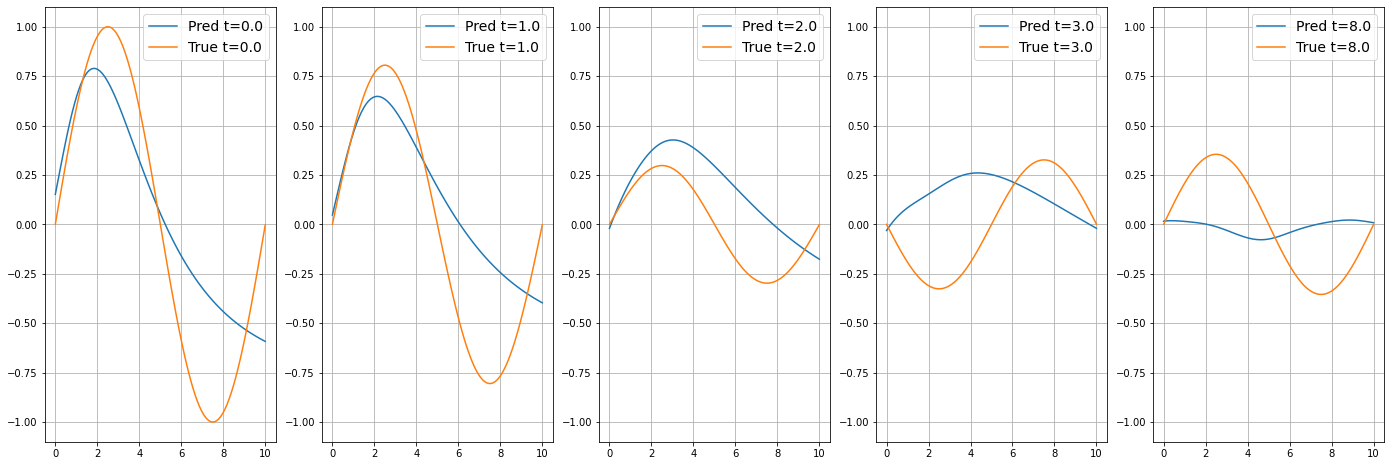

In [107]:
plot_evolution(xt_train, network, ylim=[-1.1,1.1])

The fit is not the greatest. Let us try out another optimizers.

## Experiments with optimizers

### Adam

In [109]:
import copy

model_Adam_1 = copy.deepcopy(network)

optimizer = torch.optim.Adam(model_Adam_1.parameters())

history = fit_model_PDE(xt_train,
                        model_Adam_1,
                        optimizer,
                        n_epochs=2000,
                        n_iter=100,
                        f=f)

Epoch: 0, Loss: 0.16957
Epoch: 100, Loss: 0.13736
Epoch: 200, Loss: 0.10481
Epoch: 300, Loss: 0.05478
Epoch: 400, Loss: 0.02368
Epoch: 500, Loss: 0.01422
Epoch: 600, Loss: 0.00929
Epoch: 700, Loss: 0.00774
Epoch: 800, Loss: 0.00616
Epoch: 900, Loss: 0.00558
Epoch: 1000, Loss: 0.00511
Epoch: 1100, Loss: 0.00486
Epoch: 1200, Loss: 0.0046
Epoch: 1300, Loss: 0.00441
Epoch: 1400, Loss: 0.00431
Epoch: 1500, Loss: 0.00417
Epoch: 1600, Loss: 0.00407
Epoch: 1700, Loss: 0.00399
Epoch: 1800, Loss: 0.00401
Epoch: 1900, Loss: 0.00384
Epoch: 2000, Loss: 0.0038


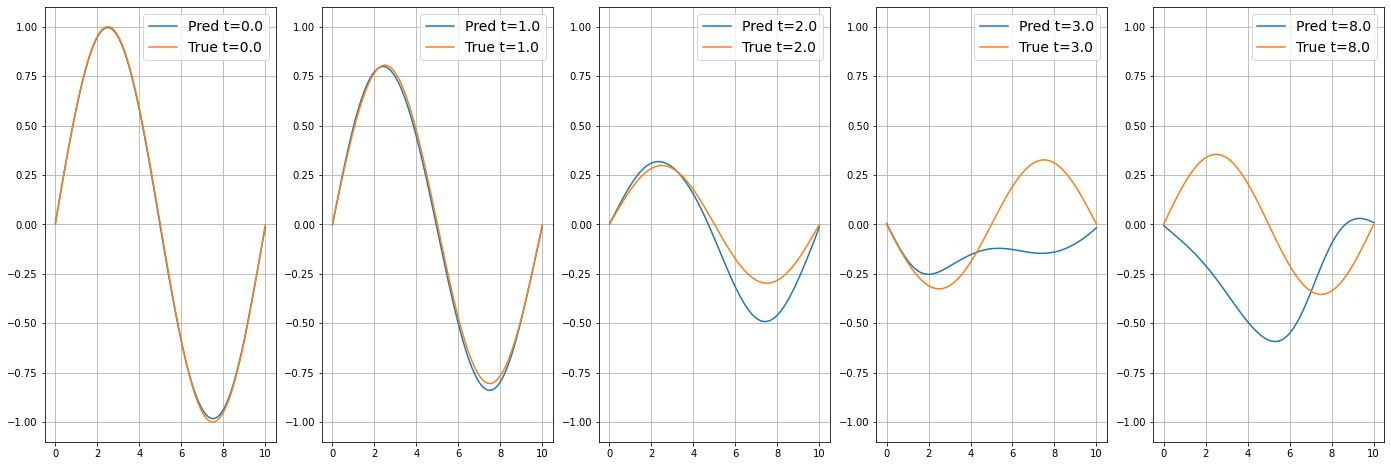

In [110]:
plot_evolution(xt_train, model_Adam_1, ylim=[-1.1,1.1])

The fit is decent. Especially in the beginning. The evolution looks good, but other modes are present. Let us decrease learning rate and try to fit the model a little bit longer

In [111]:
model_Adam_2 = copy.deepcopy(model_Adam_1)
optimizer = torch.optim.Adam(model_Adam_2.parameters(), lr=1e-5)

history = fit_model_PDE(xt_train,
                        model_Adam_2,
                        optimizer,
                        n_epochs=2000,
                        n_iter=100,
                        f=f)

Epoch: 0, Loss: 0.00381
Epoch: 100, Loss: 0.00378
Epoch: 200, Loss: 0.00377
Epoch: 300, Loss: 0.00375
Epoch: 400, Loss: 0.00373
Epoch: 500, Loss: 0.00371
Epoch: 600, Loss: 0.00369
Epoch: 700, Loss: 0.00367
Epoch: 800, Loss: 0.00365
Epoch: 900, Loss: 0.00362
Epoch: 1000, Loss: 0.0036
Epoch: 1100, Loss: 0.00358
Epoch: 1200, Loss: 0.00355
Epoch: 1300, Loss: 0.00353
Epoch: 1400, Loss: 0.0035
Epoch: 1500, Loss: 0.00348
Epoch: 1600, Loss: 0.00345
Epoch: 1700, Loss: 0.00343
Epoch: 1800, Loss: 0.00341
Epoch: 1900, Loss: 0.00339
Epoch: 2000, Loss: 0.00337


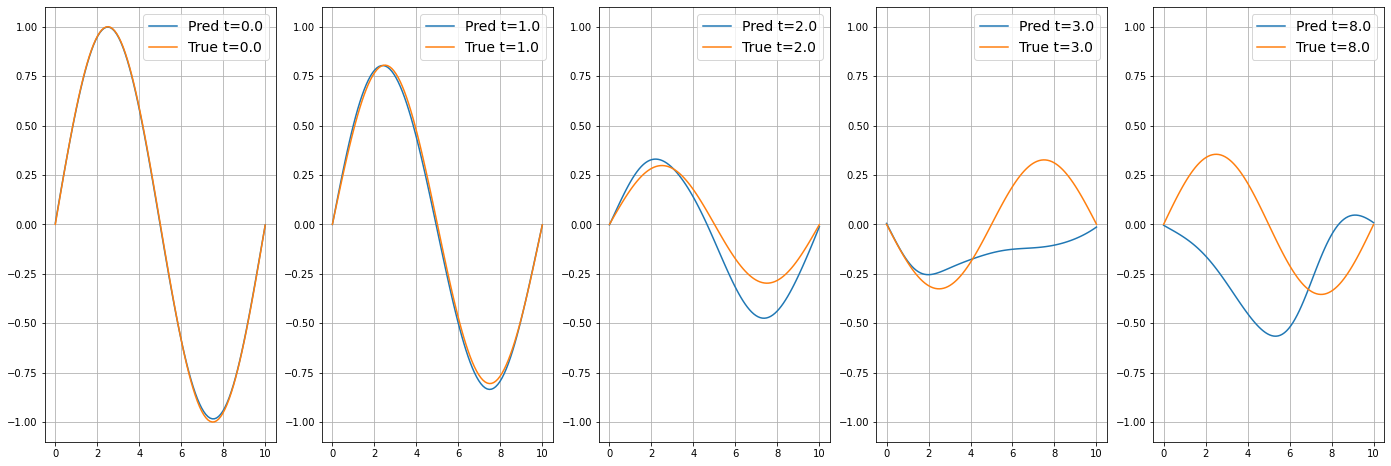

In [113]:
plot_evolution(xt_train, model_Adam_2, ylim=[-1.1,1.1])

### Adagrad

In [114]:
model_Adagrad = copy.deepcopy(network)
optimizer = torch.optim.Adam(model_Adagrad.parameters())

In [115]:
history = fit_model_PDE(xt_train,
                        model_Adagrad,
                        optimizer,
                        n_epochs=4000,
                        n_iter=100,
                        f=f)

Epoch: 0, Loss: 0.16957
Epoch: 100, Loss: 0.13736
Epoch: 200, Loss: 0.10481
Epoch: 300, Loss: 0.05478
Epoch: 400, Loss: 0.02368
Epoch: 500, Loss: 0.01422
Epoch: 600, Loss: 0.00929
Epoch: 700, Loss: 0.00774
Epoch: 800, Loss: 0.00616
Epoch: 900, Loss: 0.00558
Epoch: 1000, Loss: 0.00511
Epoch: 1100, Loss: 0.00486
Epoch: 1200, Loss: 0.0046
Epoch: 1300, Loss: 0.00441
Epoch: 1400, Loss: 0.00431
Epoch: 1500, Loss: 0.00417
Epoch: 1600, Loss: 0.00407
Epoch: 1700, Loss: 0.00399
Epoch: 1800, Loss: 0.00401
Epoch: 1900, Loss: 0.00384
Epoch: 2000, Loss: 0.0038
Epoch: 2100, Loss: 0.00373
Epoch: 2200, Loss: 0.00648
Epoch: 2300, Loss: 0.00364
Epoch: 2400, Loss: 0.00358
Epoch: 2500, Loss: 0.00353
Epoch: 2600, Loss: 0.0043
Epoch: 2700, Loss: 0.00345
Epoch: 2800, Loss: 0.00386
Epoch: 2900, Loss: 0.00339
Epoch: 3000, Loss: 0.00334
Epoch: 3100, Loss: 0.0033
Epoch: 3200, Loss: 0.00521
Epoch: 3300, Loss: 0.00324
Epoch: 3400, Loss: 0.0032
Epoch: 3500, Loss: 0.00315
Epoch: 3600, Loss: 0.00331
Epoch: 3700, Loss:

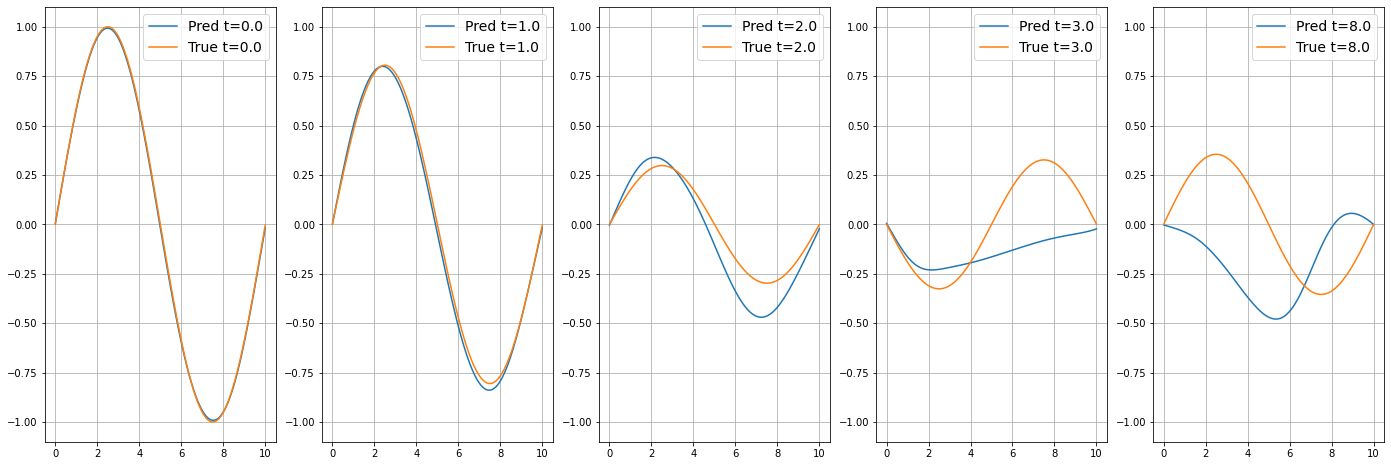

In [116]:
plot_evolution(xt_train, model_Adagrad, ylim=[-1.1,1.1])